In [ ]:
# export
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.data.all import *
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from pathlib import Path
import time
import torchvision.transforms as T
import cv2

# Reading the data 

In [ ]:
eugenio = True
path_charades = Path('/mnt/data/eugeniomarinelli/videodata') if eugenio else Path('/mnt/data/adrianlopez/Videos/Charades') 

df = pd.read_csv(path_charades/f'df.csv', index_col=0)
vid_as_series = df.loc[0]

In [ ]:
#export
def show_frames(video,start=0, end=5):
    '''show frames in a video from start to end'''
    for frame in video[start:end]:
        clear_output(wait=True)
        frame.show()
        time.sleep(0.5)

In [ ]:
vid_as_paths = L(vid_as_series.paths.split('\n'))
vid_as_paths = L(path_charades.parent/path for path in vid_as_paths)
vid_as_paths

(#223) [Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000286.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000287.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000288.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000289.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000290.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000291.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000292.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000293.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000294.jpg'),Path('/mnt/data/eugeniomarinelli/videodata/Charades_v1_rgb/46GP8/46GP8-000295.jpg')...]

# Defining the Video Class

In [ ]:
#export
@patch 
def insert(l:L, i, o):
    l.items.insert(i, o)

class Video(L):
    @classmethod
    def create(cls, paths, sep='\n'): 
        '''create images from frames path in a video'''
        paths = paths.split(sep) if isinstance(paths, str) else paths
        return cls(map(PILImage.create, paths))
    
    def show(self, i=None):
        if i == None: i = random.randint(0, len(self)-1)
        show_image(self[i])        
            
    def __mul__(self, n):
        neg = n < 0
        if n==0 or abs(n) >=1: return self[[(i+neg)//n for i in range(abs(int(n))*len(self))]]
        else: return self/(1/n)
        
    def __truediv__(self, n):
        n = int(n)
        return self[::n]
    
    def __rmul__(self, n):
        return self*n
    
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else Video(self._get(idx), use_list=None)      
    

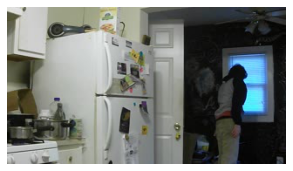

In [ ]:
vid_as_imgs = Video.create(vid_as_paths)
vid_as_imgs.show()

# Transforms of the video pipeline 

In [ ]:
#export
def snippets_from_video(vid, l=10, s=2):
    '''create list of snippet out a video'''
    vid=vid[::s] # skip frames
    return [Video([vid[i] for i in range(k*l, k*l + l)]) for k in range(0,len(vid)//l)]
        
def stretch(vid, l):
    vid = vid*(l//len(vid))
    if len(vid) == l: return vid
    lv = len(vid)
    n = l - lv                     # Number of frames to be inserted
    d = lv//n                      # Number of frames between inserted frames
    idxs = L(range(lv))
    for i in range(n):
        idxs.insert((d+1)*i, d*i)
    return vid[idxs]

class ResizeTime(Transform):
    split_idx = None # 0- train 1- validation 
    def __init__(self, skip=2, l=50, drop_last=True,**kwargs): 
        self.skip = skip
        self.l = l
        self.drop_last = drop_last
        super().__init__(**kwargs)
        
    def encodes(self, vid:Video, split_idx=split_idx):
        '''create a list of frame-images (snippet) out a single video path'''
        l, skip, l_vid = self.l, self.skip, len(vid)
        if l_vid > l*skip:
            snippet_list = snippets_from_video(vid,s=skip,l=l)
            idx = len(snippet_list)//2 if split_idx else random.randint(0,len(snippet_list)-1) # ** if validation always takes middle snip
            return snippet_list[idx]     
        else:
            vid = vid[::skip]
            vid = stretch(vid, l)         
        return vid

In [ ]:
test_eq(len(ResizeTime(50)(vid_as_imgs)), 50)

In [ ]:
#export
class TensorVideo(TensorBase): pass

@ToTensor
def encodes(self, vid:Video):
    return TensorVideo(vid.stack().permute(3,0,1,2))

In [ ]:
#export
@Resize
def encodes(self, video:Video):
    return video.map(partial(Resize.encodes[PILImage], self))

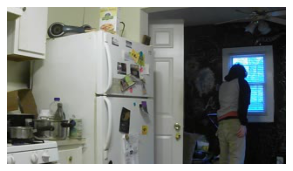

In [ ]:
vid_resized = Resize(224, method=ResizeMethod.Pad)(vid_as_imgs)
vid_resized.show()

In [ ]:
#export
class TensorVideo(TensorBase):
    def show(self, i=None):
        if i == None: i = random.randint(0, self.size(1)-1)
        show_image(self[:,i])
            
@ToTensor
def encodes(self, vid:Video):
    return TensorVideo(vid.stack().permute(3,0,1,2))

@Resize
def encodes(self, video:TensorVideo):
    return T.Resize(self.size)(video)

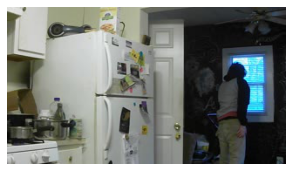

In [ ]:
vid_tensor = ToTensor()(vid_resized)
vid_tensor.show()

In [ ]:
#export
@IntToFloatTensor
def encodes(self, vid:TensorVideo):
    return vid.float()/self.div if vid.dtype==torch.uint8 else vid

In [ ]:
IntToFloatTensor()(vid_tensor).max()

TensorVideo(1.)

# Creating Video/TensorVideo from mp4

In [ ]:
#export
def repeat_video(vid, l):
    """Repeats video "vid" until it reaches target length "l" """
    reap = l // len(vid)
    delta = l % len(vid)
    vid = vid * reap + vid[0:delta]
    return vid

def create_video(vid_path, start=None, l=50, skip=3, form='tens'):
    assert form in ['tens', 'img'], "form should be either 'tens' or 'img'"
    vidcap = cv2.VideoCapture(str(vid_path))
    duration = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    
    if l=='all': start, l = 0, duration//skip
    elif start is None: start = random.randint(0, max(0, duration-l*skip))
    vid = L()
    for i, frame_pos in enumerate(range(start, start+l*skip, skip)):
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        res, frame = vidcap.read()
        if res: vid.append(frame)
        else: vid = repeat_video(vid, l); break 
            
    vidcap.release()
    if form == 'tens': return TensorVideo(vid.stack().permute(3,0,1,2))
    else: return vid.map(PILImage.create)
            
        
class createVideoForm(Transform):
    '''Create a TensorVideo using form=tens or a list of PIL images using form=img '''
    def __init__(self, l='all', skip=3, form='tens'):
        self.l = l
        self.skip = skip
        self.form = form
    def encodes(self, vid_path): return create_video(vid_path, l=self.l, skip=self.skip, form=self.form)

In [ ]:
vid_paths = get_files('/mnt/data/eugeniomarinelli/UCF_Crimes/Videos', extensions='.mp4')
vid_path = random.choice(vid_paths)
ts_vid = createVideoForm(l=30, skip=3)(vid_path)

In [ ]:
ts_vid.shape

(3, 30, 240, 320)

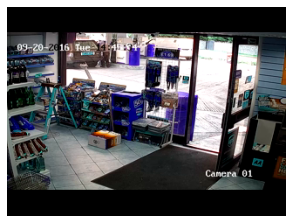

In [ ]:
ts_vid.show()

# Augmentation Tranforms 

In [ ]:
class RandomCrop(Transform):
    def __init__(self, size: tuple ):
        self.size = size
    def encodes(self, ts_vd):
        return T.RandomCrop(self.size)(ts_vd)
    
class RandomHFlip(Transform):
    def __init__(self, p ):
        self.p = p
    def encodes(self, ts_vd):
        return T.RandomHorizontalFlip(self.p)(ts_vd)

class RandomColorJitter(Transform):
    def __init__(self,brightness=0, contrast=0, saturation=0, hue=0):
          self.transform = T.ColorJitter(brightness= brightness, contrast=contrast, saturation=saturation, hue=hue)
    def encodes(self, ts_vid):
        return self.transform(ts_vid.permute(1,0,2,3)).permute(1,0,2,3)

# Uniformizing the dataset 

In [ ]:
#export
def uniformize_dataset(items, lbls, vocab=None, n_el=3, n_lbl=3, shuffle=True):
    if vocab is None: vocab = list(set(lbls))
    lbl2idxs = {lbl:[] for lbl in vocab}
    for i, lbl in enumerate(lbls): lbl2idxs[lbl].append(i)
    for lbl, idxs in lbl2idxs.items(): 
        if len(idxs) < n_el: vocab.remove(lbl)       
    if shuffle: [random.shuffle(v) for v in lbl2idxs.values()]
    idxs = []
    while len(vocab) >= n_lbl:
        lbl_samples = random.sample(vocab, n_lbl)
        for lbl in lbl_samples:
            i = 0
            while i < n_el:
                i += 1
                idx = lbl2idxs[lbl].pop()
                idxs.append(idx)
            if len(lbl2idxs[lbl]) <= n_el:
                vocab.remove(lbl)
    return [items[idx] for idx in idxs] if isinstance(items, list) else getattr(items, 'iloc', items)[idxs]

In [ ]:
items = pd.read_csv(path_charades/'df0.csv', index_col=0)
items = uniformize_dataset(items, items['lbl'])
items.tail(6)

,id,coded_lbl,lbl,start,end,val
25701,2EPFZ,c059,Sitting in a chair,13.3,32.2,False
62995,5SBEY,c059,Sitting in a chair,10.7,16.0,True
36955,ICXAE,c059,Sitting in a chair,0.0,13.4,False
60644,1KC11,c154,Someone is standing up from somewhere,27.6,32.1,True
12697,G9JMG,c154,Someone is standing up from somewhere,19.5,24.7,False
54745,1LBUG,c154,Someone is standing up from somewhere,29.5,32.0,True


In [ ]:
lbls = list(items['lbl'])
uniformize_dataset(lbls, lbls)[-5:]

['Walking through a doorway',
 'Walking through a doorway',
 'Someone is standing up from somewhere',
 'Someone is standing up from somewhere',
 'Someone is standing up from somewhere']

In [ ]:
#export
class UniformizedShuffle():
    def __init__(self, lbls, vocab=None, n_el=4, n_lbl=4):
        self.lbls = lbls
        if vocab is None: vocab = list(set(lbls))
        self.vocab = vocab
        self.n_el = n_el
        self.n_lbl = n_lbl
    def __call__ (self, items):
        return uniformize_dataset(items, lbls=self.lbls.copy(), vocab=self.vocab.copy(), n_el=self.n_el, n_lbl=self.n_lbl)

In [ ]:
df = pd.read_csv(path_charades/'df0.csv', index_col=0)
un = UniformizedShuffle(items['lbl'])
un(items).tail(7)

,id,coded_lbl,lbl,start,end,val
29646,67EEN,c154,Someone is standing up from somewhere,12.8,18.7,False
6672,IYVVM,c154,Someone is standing up from somewhere,19.2,24.2,False
49543,O03Y4,c154,Someone is standing up from somewhere,0.0,17.0,False
35697,NWFOF,c097,Walking through a doorway,19.8,26.6,False
57649,FTYFA,c097,Walking through a doorway,0.0,4.9,True
59413,KCRQU,c097,Walking through a doorway,0.8,6.5,True
10909,O18DS,c097,Walking through a doorway,0.0,11.6,False


In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_losses_tmp.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 05_charades.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_transformer.ipynb.
Converted 09_lr_schedule.ipynb.
Converted 10_experiments_on_images.ipynb.
Converted 11_create_embeddings.ipynb.
Converted 12_load_r2p1d_model.ipynb.
Converted CALTECH101_MixedLoss.ipynb.
Converted CALTECH101_singleloss.ipynb.
Converted UCF101.ipynb.
Converted UCF_Crimes_CEL.ipynb.
Converted UCF_Crimes_SupCon.ipynb.
Converted index.ipynb.


In [ ]:
# default_exp video_block